# Pairs Trading

Pairs Trading is a market-neutral trading strategy which involves matching a long position with a short position in two securities which have a high level of positive correlation. It is a form of statistical arbitrage i.e it looks at the relative price movement between the two securities.

As it is a market-neutral strategy, it is independent of the trend being followed by the overall market (upwards or downwards). Instead, pairs trading works on the concept of mean-reversion. When two highly correlated securites deviate from their general trend, it is expected that they will return back to that trend in the future.

The spread between the stock prices created during the deviation serves as an opportunity for profit. One can open a long position on the stock expected to move upwards and a short position on the stock expected to move downwards. If the pair performs as expected, it is a profitable trade.

Even if the pair does not perform as expected, the trader will be able to mitigate some portion of their losses as the loss on one security will be offset by the profits on the other security. Hence, pairs trading also acts as a form of hedging and can be used to minimise losses.


# **Importing Libraries**

In [1]:
!pip install pandas_ta

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from statsmodels.tsa.stattools import coint, adfuller
import pandas_ta as ta
import statsmodels
import statsmodels.api as sm

# **Importing Stock Price dataset**
For the purpose of this strategy, a lookback period of Three years from June 2017 to June 2020 will be used to identify stock pairs. In particular, stocks from the banking sector will be considered and hence the stocks of the NIFTY IT index have been taken.

In [3]:
start_date = "2017-06-01"
end_date = "2020-06-01"

stocks = ["INFY.NS", "TCS.NS", "BHARTIARTL.NS", "HCLTECH.NS", "TECHM.NS", "LTIM.NS", "WIPRO.NS", "MPHASIS.NS", "ZENSARTECH.NS", "ZEEL.NS"] 


**This algo can also be tested for the following sectors and more, it will generate decent statistics there too, we can also with more time in our hands try to develop and upgrade our strategy further.**

In [4]:
#stocks = ["ULTRACEMCO.NS","SHREECEM.NS","AMBUJACEM.NS","JKCEMENT.NS","INDIACEM.NS","SHREECEM.NS"] #, Cement sector stocks
#stocks = ["APOLLOHOSP.NS","FORTIS.NS","NH.NS","LALPATHLAB.NS"] #, Healthcare sector stocks
#stocks = ["INDUSINDBK.NS", "HDFCBANK.NS", "PNB.NS", "ICICIBANK.NS", "BANKBARODA.NS", "SBIN.NS", "IDFCFIRSTB.NS", "KOTAKBANK.NS", "FEDERALBNK.NS"] #, Banking sector stocks

In [5]:
stock_data =  yf.download(stocks, start = start_date ,end= end_date)['Adj Close']
stock_data.head()

[*********************100%%**********************]  10 of 10 completed


,BHARTIARTL.NS,HCLTECH.NS,INFY.NS,LTIM.NS,MPHASIS.NS,TCS.NS,TECHM.NS,WIPRO.NS,ZEEL.NS,ZENSARTECH.NS
Date,,,,,,,,,,
2017-06-01,324.994232,373.410431,411.021851,715.339539,499.071411,1112.993530,316.709503,197.974121,497.965424,150.806030
2017-06-02,330.618988,371.526550,410.196777,707.934143,511.355499,1117.918579,318.222595,201.815430,499.062408,152.256073
2017-06-05,329.866089,371.873108,405.669342,706.985962,501.627106,1134.938843,320.731079,203.242218,500.493469,151.766891
2017-06-06,326.854370,385.189789,414.385712,710.282104,511.520386,1175.058960,325.429565,205.071381,494.865051,152.395828
2017-06-07,330.220398,381.313843,406.748291,724.415588,514.941772,1139.863892,318.461487,200.992294,495.342041,152.360870


## **Identifying stock pairs**

## **Cointegration**
Cointegration is a statistical method which is used to identify the correlation between two non-stationary time series in the long run or over a specified period.

Finding stock pairs with cointegrated time series:

We check the cointegration for all pairs and store those with cointegration value less than 0.05

In [6]:
def cointegration_test(stock_data, stocks):
    N = stock_data.shape[1]
    pvalues = np.ones((N, N))
    correl = np.ones((N, N))
    stock_pairs = []

    for i in range(N):
      for j in range(N):
        if i == j:
          continue

        result = coint(stock_data[stocks[i]], stock_data[stocks[j]])
        pval = result[1]
        pvalues[i][j] = pval
        correl[i][j] = stock_data[stocks[i]].corr(stock_data[stocks[j]])
        if(pval < 0.05 and stocks[i] != stocks[j]):                   # Cutoff threshold for 95% confidence
          stock_pairs.append((pval, (stocks[i], stocks[j]),correl[i][j]))

    return pvalues, stock_pairs,correl

Plotting the heatmap for cointegration

<Axes: >

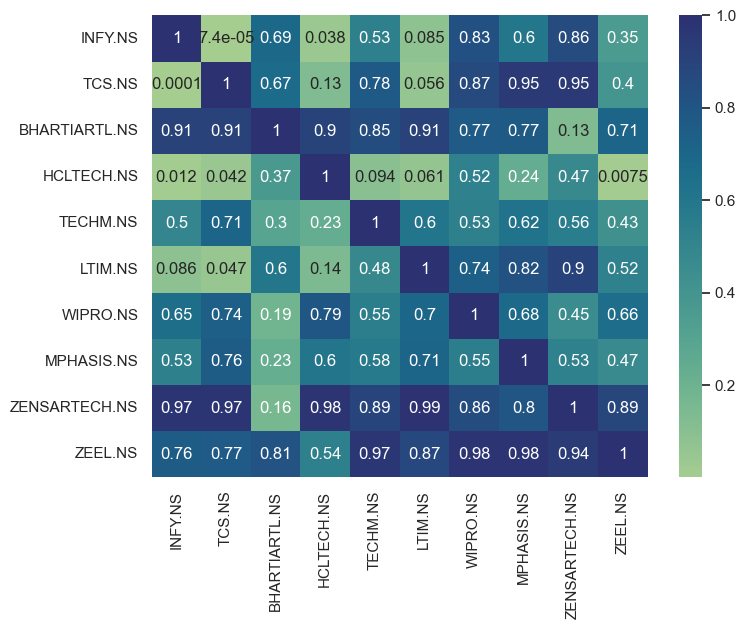

In [7]:
pvalues, stock_pairs,correl = cointegration_test(stock_data, stocks)
from matplotlib.pyplot import figure
stock_pairs
figure(figsize=(8, 6), dpi=100)
sns.heatmap(pvalues, xticklabels = stocks, yticklabels = stocks, cmap = 'crest',  annot = True)

Plotting the heatmap for correlation for all pairs

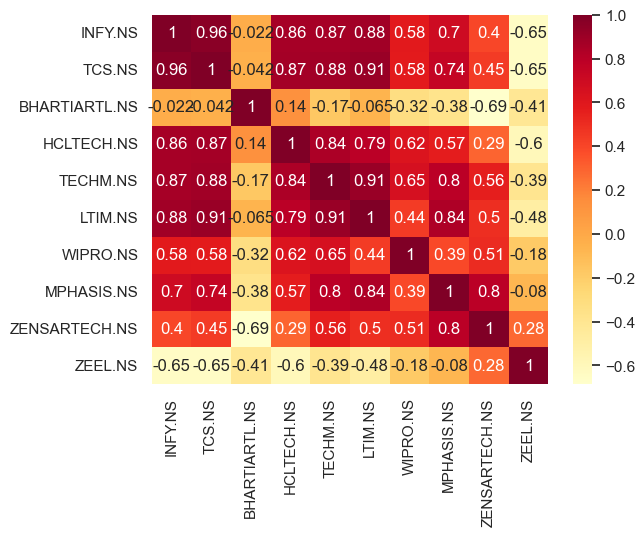

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your stock_data, stocks, and the other required variables set up

# Create the heatmap with the 'YlOrRd' colormap
sns.heatmap(correl, xticklabels=stocks, yticklabels=stocks, cmap='YlOrRd', annot=True)

# Show the heatmap
plt.show()


The pairs of stocks having a cointegration are those with a p-value less than the threshold of 0.05. P-value can be considered as a measure of the strength of cointegration between the two series. A lower p-value indicates a stronger cointegration

Creating a DataFrame for Correlations of pair with a p-value less than the threshold

In [9]:
df=pd.DataFrame()

# Split the data into two separate lists
values = [item[2] for item in stock_pairs]
stock1 = [item[1][0]for item in stock_pairs]
stock2 = [item[1][1]for item in stock_pairs]
# Create a DataFrame
df = pd.DataFrame({'Correl': values, 'stock1':stock1,'stock2':stock2})

stock_pairs
print(df)

x = min(df['Correl'])

     Correl      stock1      stock2
0  0.960620     INFY.NS      TCS.NS
1  0.863134     INFY.NS  HCLTECH.NS
2  0.960620      TCS.NS     INFY.NS
3  0.863134  HCLTECH.NS     INFY.NS
4  0.873049  HCLTECH.NS      TCS.NS
5 -0.597657  HCLTECH.NS     ZEEL.NS
6  0.912000     LTIM.NS      TCS.NS


Implementing our strategy where we see the correlation, if there is a negative value there, we choose the pair with the least value while if there are not any negative elements we choose the pair with the maximum correlation.

In [10]:
if x<0:
    max_corr_row = df.loc[df['Correl'].idxmin()]
else:
    max_corr_row = df.loc[df['Correl'].idxmax()]
max_corr_row

stock1_with_max_corr = max_corr_row['stock1']
stock2_with_max_corr = max_corr_row['stock2']

**Selected pair: HCLTECH & ZEEL**

Plotting their prices

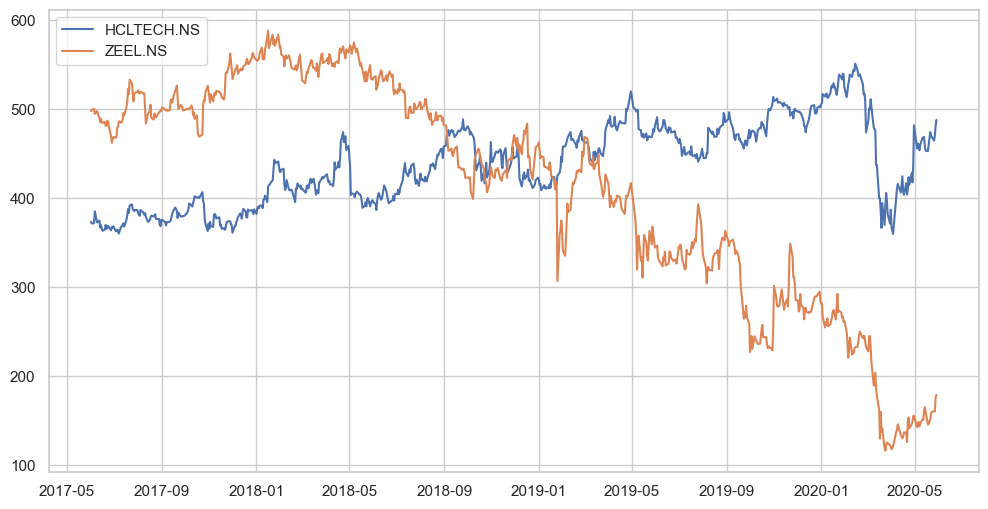

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(stock_data[stock1_with_max_corr], label = stock1_with_max_corr )
plt.plot(stock_data[stock2_with_max_corr], label = stock2_with_max_corr)
plt.legend()
plt.show()

ADF can also be used but our main strategy is focussed upon correlations and cointegrations of stock pairs

In [12]:
# from statsmodels.tsa.stattools import adfuller
# # Compute the ADF test for Berkshire Hathaway and Microsoft
# # With all time series, you want to have stationary data otherwise our data will be very hard to predict.
# # ADF for Berkshire Hathaway Class B
# one = stock_data[stock1_with_max_corr]
# two = stock_data[stock2_with_max_corr]
# one_adf = adfuller(one)
# print('P value for the Augmented Dickey-Fuller Test is', one_adf[1])
# two_adf = adfuller(two)
# print('P value for the Augmented Dickey-Fuller Test is', two_adf[1])
# Spread_ADF = adfuller(one - two)
# print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
# Ratio_ADF = adfuller(one / two)
# print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# # Spread looks fine. If you'd want even better results, consider taking the difference (order 1) of Berkshire and MSFT

# # Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# # Therefore, the two series are cointegrated.

Same goes with price ratio

In [13]:
# figure(figsize=(12, 6), dpi=200)
# ratio = one / two
# plt.plot(ratio, label = 'Price Ratio ')
# plt.axhline(ratio.mean(), color='red')
# plt.legend()
# plt.title("Price Ratio")

### **Testing Data**

The strategy will use a 3 month testing period from July 2020 to July 2023. The spread between the prices of the two stocks will be used to determine points of entry and exit for the pairs trade.

Looking at the spread for the selected pair

We use the a linear regression model from the "statsmodels" python library to calculate the 'beta' of the spread

[*********************100%%**********************]  2 of 2 completed


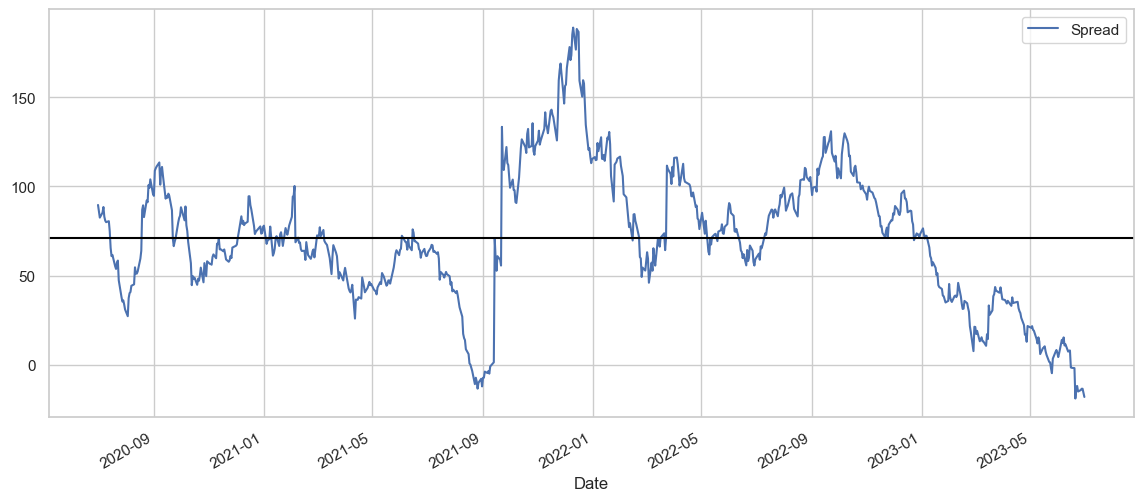

In [14]:

stock_pair = [stock1_with_max_corr, stock2_with_max_corr]
asset_pairs =  yf.download(stock_pair, start="2020-07-01" ,end= "2023-07-01")['Adj Close']

S1=asset_pairs[stock_pair[0]]
S2=asset_pairs[stock_pair[1]]

S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1[stock_pair[0]]
b = results.params[stock_pair[0]]

spread = S2 - b* S1
spread.plot(figsize=(14, 6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']) 

## **Z-Score**

A Z-score is a numerical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. Z-scores also make it possible to adapt values from data sets having a very different ranges to make scores that are comparable.
Essentially, z-scores can shrink a large range of values into a much smaller range which is easier to handle.

Zscore.svg

𝒳 = series

μ = series mean

σ = series standard deviation

We take a lookback period of 20 to calculate our Zscore

In [15]:
def zscore(series):
    lookback = 20
    scores = []
    for i in range(lookback, len(series)):
      window = series[i-lookback:i]
      scores.append((series[i]-window.mean())/window.std())
    return pd.Series(scores, index = series.index[lookback:])

Plotting the Zscore

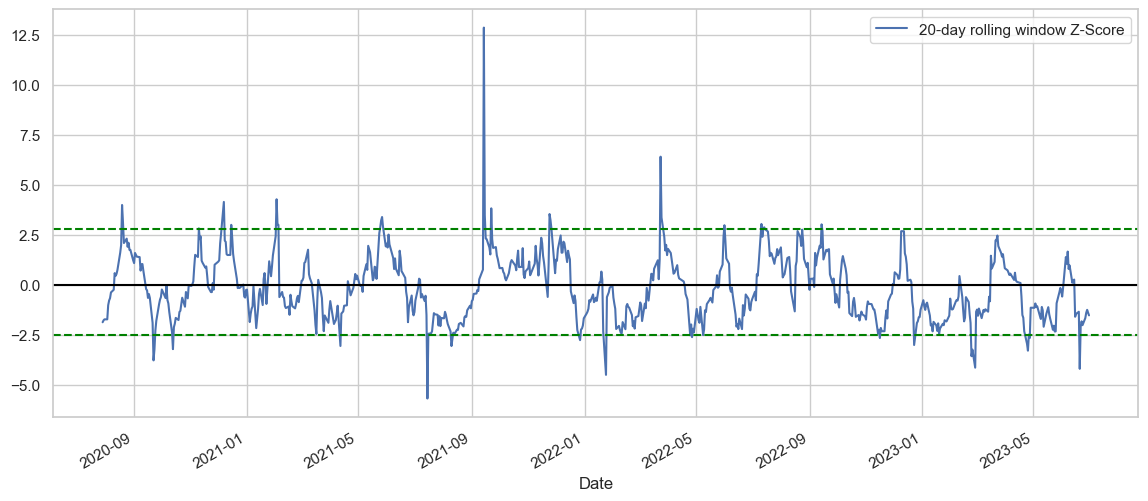

In [16]:
zscore(spread).plot(figsize=(14, 6))
plt.axhline(0.0, color='black')
plt.axhline(2.8, color='green', linestyle='--')
plt.axhline(-2.5, color='green', linestyle='--')
plt.legend(['20-day rolling window Z-Score'])

##
Now here we would like to add that our strategy is currently not able to get optimal values for our Zscore thresholds, but we think we can develop some algorithm to get these optimal thresholds for maximising our profit margins.

## **Trading Strategy**

Implementation of a simple mean-reversion based strategy. The threshold levels for the Z-score are taken as +2.8 and -2.5. Whenever the Z-score value rises above +2.8, it is expected to fall in the future and a short position is taken on the pair. Similarly, when the Z-score value falls below -2.5, it is expected to rise in the future and a long position is taken on the pair.


In [17]:
def generate_trade_signals(S1, S2, spread):
  signals = pd.DataFrame()
  signals['price1'] = S1
  signals['price2'] = S2
  signals['spread'] = spread
  signals['zscore'] = zscore(spread)

  signals.dropna(inplace = True)

  signals['signal1'] = np.select([signals['zscore'] > 2.8, signals['zscore'] < -2.5], [1, -1], default = 0)
  signals['position1'] = signals['signal1'].diff()
  signals['signal2'] = -signals['signal1']
  signals['position2'] = signals['signal2'].diff()

  return signals

These signals we generated are based on the above mentioned theory of our threshold zscore values and current zscore value intersecting, based of that we take positions on our stocks.

In [18]:
trade_signals = generate_trade_signals(S1, S2, spread)
trade_signals.dropna(inplace = True)
trade_signals

,price1,price2,spread,zscore,signal1,position1,signal2,position2
Date,,,,,,,,
2020-07-30,618.634277,136.510529,33.841307,-1.791905,0,0.0,0,0.0
2020-07-31,627.307312,135.098709,30.990101,-1.741183,0,0.0,0,0.0
2020-08-03,627.974548,131.398697,27.179354,-1.741165,0,0.0,0,0.0
2020-08-04,616.143616,139.577667,37.321799,-1.033266,0,0.0,0,0.0
2020-08-05,612.362976,141.719742,40.091312,-0.798777,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...
2023-06-23,1155.183350,176.649994,-15.065499,-2.032049,0,0.0,0,0.0
2023-06-26,1157.513184,177.850006,-14.252148,-1.678837,0,0.0,0,0.0
2023-06-27,1159.991821,179.000000,-13.513512,-1.413577,0,0.0,0,0.0


### **Visualising the positions**

**1) Trades on the pair**

In [19]:
def plot_pair_trades(trade_signals):
  fig = plt.figure(figsize=(14, 6))
  bx = fig.add_subplot(111)
  series = bx.plot(trade_signals['zscore'], c='#4abdac')
  long = bx.plot(trade_signals['zscore'][trade_signals['position1'] == -1], lw = 0, marker = '^', markersize = 8, c = 'g', alpha = 0.9)
  short = bx.plot(trade_signals['zscore'][trade_signals['position1'] == 1], lw = 0, marker = 'v', markersize = 8, c = 'r', alpha = 0.9)
  stock1 = stock_pair[0]
  stock2 = stock_pair[1]
  plt.title(f'{stock2} / {stock1}')
  plt.legend(['Z-Score', 'Long', 'Short'])

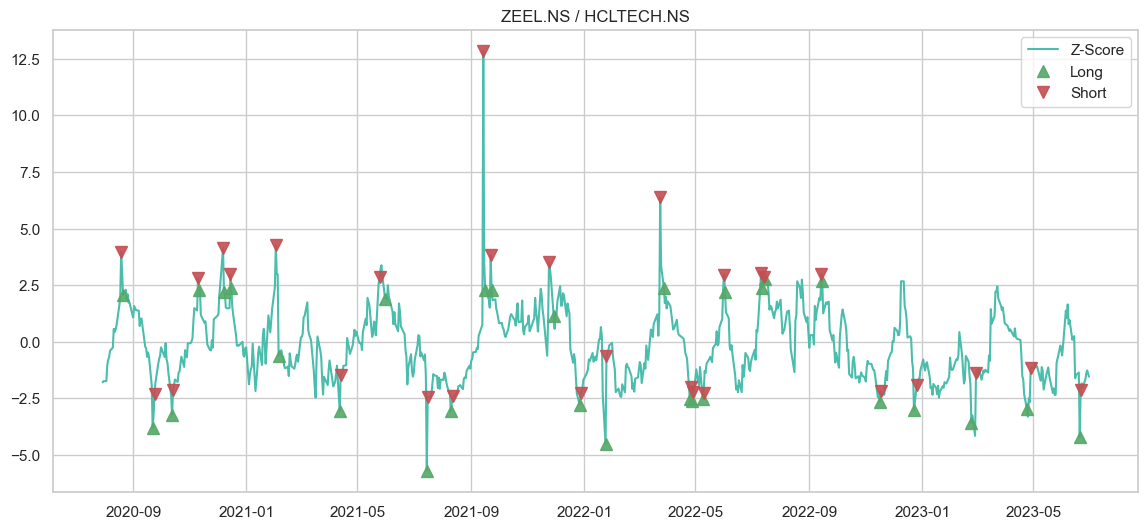

In [20]:
plot_pair_trades(trade_signals)

Here we can see the positions our algo took 

*   **Long position => buy ZEEL and sell HCLTECH**
*   **Short position => sell ZEEL and buy HCLTECH**

**2) Trades on HCLTECH**

In [21]:
def plot_trades_1(signals):
  fig = plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price1'], c='#4abdac')
  u1 = bx.plot(signals['price1'][signals['position1'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2, = bx.plot(signals['price1'][signals['position1'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[0])
  plt.legend(['Price', 'Long', 'Short'])

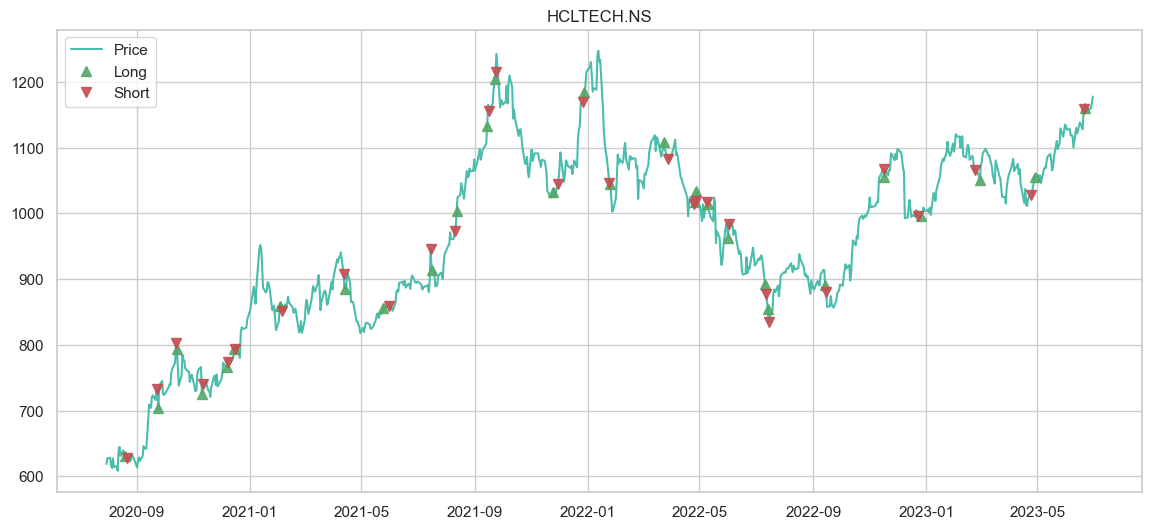

In [22]:
plot_trades_1(trade_signals)

**3) Trades on ZEEL**

In [23]:
def plot_trades_2(signals):
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)
  l1 = bx.plot(signals['price2'], c='#4abdac')
  u1 = bx.plot(signals['price2'][signals['position2'] == 1], lw=0, marker='^', markersize=7, c='g',alpha=0.9)
  u2 = bx.plot(signals['price2'][signals['position2'] == -1], lw=0, marker='v', markersize=7, c='r',alpha=0.9)
  plt.title(stock_pair[1])
  plt.legend(['Price', 'Long', 'Short'])

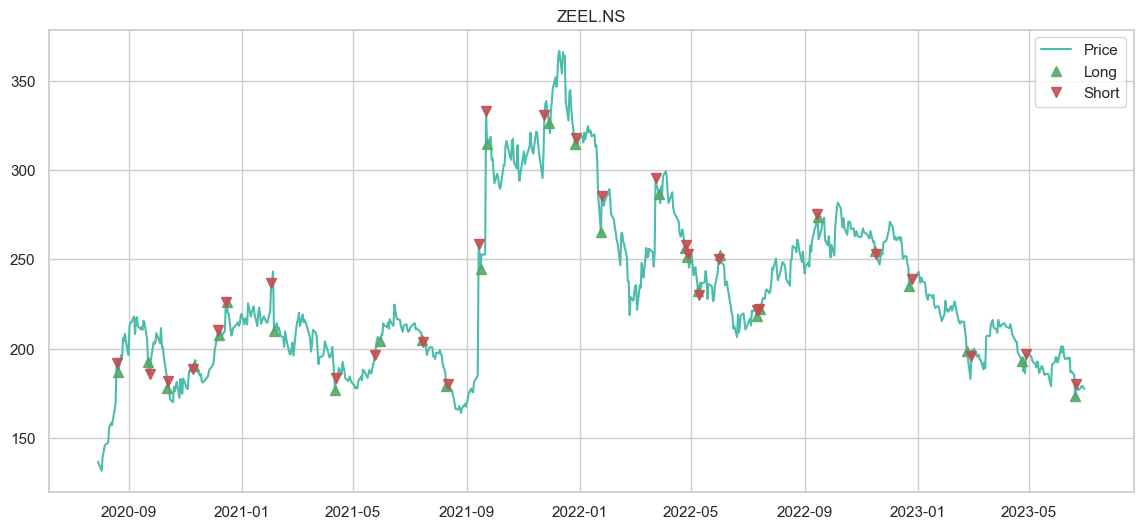

In [24]:
plot_trades_2(trade_signals)

## **Portfolio Performance**

### **PnL Calculation**

In [25]:
def pnl_calculation(signals):

  initial_capital = 100000

  # Shares to buy for each stock
  shares1 = initial_capital// (signals['price1'][0])
  shares2 = initial_capital// (signals['price2'][0])

  #PnL for stock 1
  portfolio = pd.DataFrame()
  portfolio['holdings1'] = signals['position1'].cumsum() * signals['price1'] * shares1
  portfolio['cash1'] = initial_capital - (signals['position1'] * signals['price1'] * shares1).cumsum()
  portfolio['total1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total1'].pct_change()

  # PnL for stock 2
  portfolio['holdings2'] = signals['position2'].cumsum() * signals['price2'] * shares2
  portfolio['cash2'] = initial_capital - (signals['position2'] * signals['price2'] * shares2).cumsum()
  portfolio['total2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total2'].pct_change()

  # Total PnL
  portfolio['total'] = portfolio['total1'] + portfolio['total2']
  portfolio = portfolio.dropna()

  return portfolio

In [26]:
portfolio = pnl_calculation(trade_signals)
portfolio.head()

,holdings1,cash1,total1,return1,holdings2,cash2,total2,return2,total
Date,,,,,,,,,
2020-07-31,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-08-03,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-08-04,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-08-05,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0
2020-08-06,0.0,100000.0,100000.0,0.0,0.0,100000.0,100000.0,0.0,200000.0


In [27]:
def plot_portfolio_value(portfolio):

  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  l1, = ax.plot(portfolio['total'], c='g')
  ax.set_ylabel('Asset Value')
  ax.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance PnL')
  plt.legend(['Total Portfolio Value'])

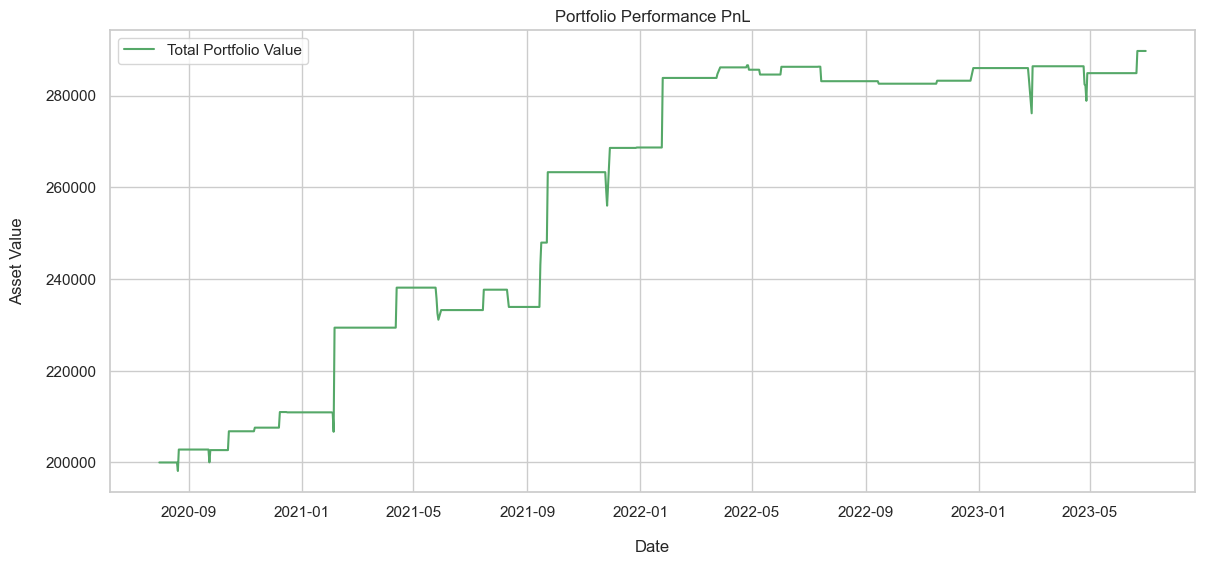

In [28]:
plot_portfolio_value(portfolio)

## **Portfolio Returns**

In [29]:
cumulative_returns = ((portfolio['total'].iloc[-1] - portfolio['total'].iloc[0])/portfolio['total'].iloc[0])*100
print("Cumulative Returns of our strategy is ",cumulative_returns)

Cumulative Returns of our strategy is  44.86535726928711


In [30]:
def calculate_cagr(portfolio):

  final_portfolio = portfolio['total'].iloc[-1]
  initial_portfolio = portfolio['total'].iloc[0]
  delta = len(portfolio.index)
  print('Number of trading days = ', delta)
  YEAR_DAYS = 252
  returns = (final_portfolio/initial_portfolio) ** (YEAR_DAYS/delta) - 1
  return returns

In [31]:
print('CAGR = {:.3f}%' .format(calculate_cagr(portfolio) * 100))

Number of trading days =  725
CAGR = 13.749%


In [32]:
max_drawdown = (-max(portfolio['total']) + min(portfolio['total'])) / max(portfolio['total'])*100
print("Maximum Drawdown(%) of our strategy is ",max_drawdown)

Maximum Drawdown(%) of our strategy is  -31.609923564895183


In [33]:

# Calculate daily returns for the portfolio
portfolio['Daily_Return'] = portfolio['total'].pct_change()

# Calculate daily returns for Stock 1 and Stock 2
portfolio['Stock1_Return'] = portfolio['total1'].pct_change()
portfolio['Stock2_Return'] = portfolio['total2'].pct_change()

# Calculate average daily portfolio return
average_daily_return = portfolio['Daily_Return'].mean()

# Calculate the daily risk-free rate
# You need to input the risk-free rate for the period you're analyzing
daily_risk_free_rate = 0.07/252  # Example rate (annual rate divided by 252 trading days)

# Calculate daily excess return for the portfolio
portfolio['Daily_Excess_Return'] = portfolio['Daily_Return'] - daily_risk_free_rate

# Calculate the standard deviation of daily excess returns
standard_deviation = portfolio['Daily_Excess_Return'].std()

# Calculate the annual Sharpe Ratio
# Using 252 trading days as an approximation for the number of trading days in a year
sharpe_ratio = (average_daily_return / standard_deviation) * np.sqrt(252)

print("Annual Sharpe Ratio:", sharpe_ratio)

Annual Sharpe Ratio: 1.27972556765028


timestamp
2020-12-31    12
2021-12-31    18
2022-12-31    22
2023-12-31     6
Freq: A-DEC, dtype: int64


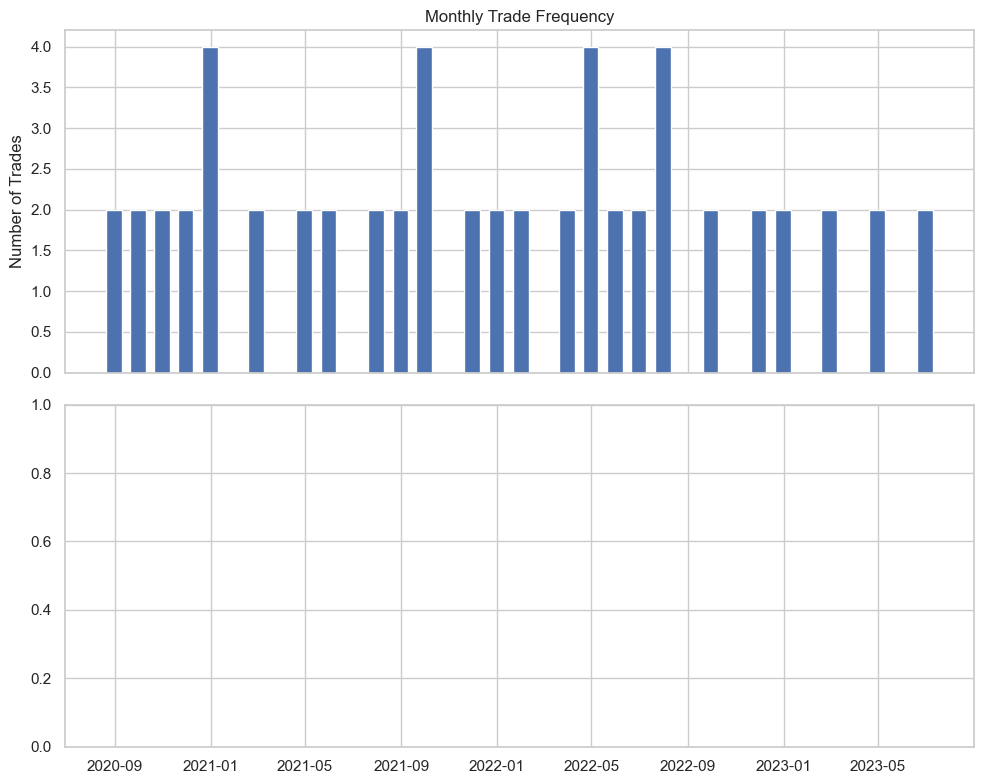

In [34]:
result_df = trade_signals[trade_signals['position1'] != 0]
# result_df.index
trades = pd.DataFrame({
    'timestamp':result_df.index
    # other trade-related columns...
})
trades['timestamp'] = pd.to_datetime(trades['timestamp'])
trades.set_index('timestamp', inplace=True)
time_interval = 'Y'
yearly_data = trades.resample(time_interval).size()
print(yearly_data)
time_interval = 'M'
monthly_data = trades.resample(time_interval).size()
# print(monthly_data)

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot for monthly data
axes[0].bar(monthly_data.index, monthly_data, color='b', width=20)  # Adjust width as needed
axes[0].set_title('Monthly Trade Frequency')
axes[0].set_ylabel('Number of Trades')



plt.tight_layout()
plt.show()